# AUDIT-C Final Data Prep

In [1]:
%matplotlib inline

In [47]:
import datetime as dt
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import synapseclient
from synapseclient import Activity, Schema, Table, as_table_columns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
from tqdm import tqdm

init_notebook_mode(connected=True)
InteractiveShell.ast_node_interactivity = 'all'
syn = synapseclient.Synapse()
syn.login()

Welcome, Luke Waninger!



In [52]:
v1sid, v2sid =  'syn10250481', 'syn9974011'

v1r = pd.read_excel(syn.get(v1sid).path, parse_dates=['response_utc'])
v2r = pd.read_csv(syn.get(v2sid).path, parse_dates=['createdAt'])

v1.head()
v2.head()

,participant_id,dt_response,alc_1,alc_2,alc_3,alc_sum
0,BLUE-00048,2014-08-01 10:56:43,4,0,3,7
1,BLUE-00049,2014-08-01 16:28:01,2,0,0,2
2,BLUE-00050,2014-08-09 02:22:18,1,0,0,1
3,BLUE-00051,2014-08-05 17:32:17,4,0,0,4
4,BLUE-00052,2014-08-04 21:23:52,1,0,0,1


,participant_id,alc_1,alc_2,alc_3,dt_response,alc_sum,dt_utc
0,EN00421,2,1.0,2.0,2016-11-11 20:33:57,5.0,2016-11-11 20:33:57
1,EN05049,2,1.0,2.0,2016-09-03 15:52:47,5.0,2016-09-03 20:52:47
2,EN05150,2,4.0,1.0,2016-10-25 22:28:35,7.0,2016-10-26 03:28:35
3,EN05109,4,1.0,1.0,2016-09-07 19:42:31,6.0,2016-09-08 00:42:31
4,EN00222,2,2.0,2.0,2016-09-07 21:25:31,6.0,2016-09-08 06:25:31


### Process V1 data

In [53]:
# drop the uneeded columns
v1 = v1r.drop(columns=[
    'sent_time_local', 'sent_time_utc', 'response_local', 'response_id', 'user_id', 'audit'
]).rename(columns={
    'brightenid': 'participant_id',
    'audit1':'alc_1',
    'audit2':'alc_2',
    'audit3':'alc_3',
    'response_utc':'dt_response'
})

# add qsum
v1['alc_sum'] = [t.alc_1 + t.alc_2 + t.alc_3 for t in v1.itertuples()]

v1.head()

,participant_id,dt_response,alc_1,alc_2,alc_3,alc_sum
0,BLUE-00048,2014-08-01 10:56:43,4,0,3,7
1,BLUE-00049,2014-08-01 16:28:01,2,0,0,2
2,BLUE-00050,2014-08-09 02:22:18,1,0,0,1
3,BLUE-00051,2014-08-05 17:32:17,4,0,0,4
4,BLUE-00052,2014-08-04 21:23:52,1,0,0,1


### Process V2 data

In [54]:
v2 = v2r.drop(columns=['day'])\
     .rename(columns={
        'How often did you have a drink containing alcohol in the past year?':'alc_1',
        'How many drinks did you have on a typical day when you were drinking in the past year?':'alc_2',
        'How often did you have six or more drinks on one occasion in the past year?':'alc_3',
        'username':'participant_id',
        'createdAt': 'dt_response'
})

# add qsum
v2['alc_sum'] = [t.alc_1 + t.alc_2 + t.alc_3 for t in v2.itertuples()]

v2.head()

,participant_id,alc_1,alc_2,alc_3,dt_response,alc_sum
0,EN00421,2,1.0,2.0,2016-11-11 20:33:57,5.0
1,EN05049,2,1.0,2.0,2016-09-03 15:52:47,5.0
2,EN05150,2,4.0,1.0,2016-10-25 22:28:35,7.0
3,EN05109,4,1.0,1.0,2016-09-07 19:42:31,6.0
4,EN00222,2,2.0,2.0,2016-09-07 21:25:31,6.0


### Combine the DataFrames

In [6]:
combined = pd.concat([v1, v2], sort=False)

# order the columns
combined = combined.loc[:,
    ['participant_id', 'dt_response', 'alc_1', 'alc_2', 'alc_3', 'alc_sum']
]

combined.head()

,participant_id,dt_response,alc_1,alc_2,alc_3,alc_sum
0,BLUE-00048,NaT,4,0.0,3.0,7.0
1,BLUE-00049,NaT,2,0.0,0.0,2.0
2,BLUE-00050,NaT,1,0.0,0.0,1.0
3,BLUE-00051,NaT,4,0.0,0.0,4.0
4,BLUE-00052,NaT,1,0.0,0.0,1.0


1    229
2    213
3    197
4    105
0     82
5      9
Name: alc_1, dtype: int64

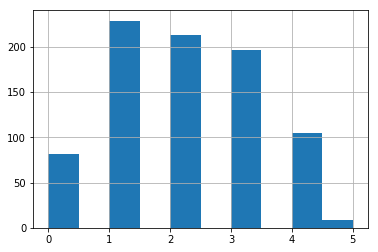

In [11]:
combined.alc_1.hist()
combined.alc_1.value_counts()

0.0    462
1.0    237
2.0     86
3.0     32
4.0     16
5.0      1
Name: alc_2, dtype: int64

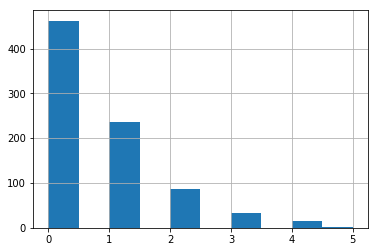

In [13]:
combined.alc_2.hist()
combined.alc_2.value_counts()

0.0    366
1.0    347
3.0     78
2.0     29
4.0     14
Name: alc_3, dtype: int64

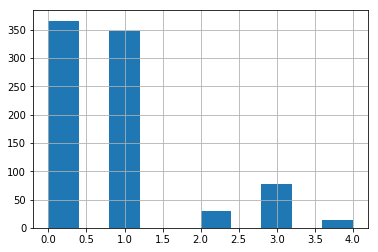

In [14]:
combined.alc_3.hist()
combined.alc_3.value_counts()

### Set provenance and upload to Synapse

In [6]:
final = syn.store(Table(
    Schema(
            name='Alcohol Consumption Survey',
            columns=as_table_columns(combined), 
            parent='syn10848316'),
        combined
    )
)

In [7]:
final = syn.setProvenance(
    'syn17021280',
    activity=Activity(
        name='Combine V1 and V2 data',
        description='Process and combine the data collected during study 1 and study 2',
        used=[v1sid, v2sid],
        executed=[
            dict(
                name='IPython Notebook',
                url='https://github.com/apratap/BRIGHTEN-Data-Release/blob/master/Create_Alcohol_datafiles.ipynb'
            )
        ]
    )
)